In [ ]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [1]:
import numpy as np
import pandas as pd # Для работы с данными
import scipy.stats # При работе со статистикой
import seaborn as sns
import matplotlib.pyplot as plt  # Библиотека для визуализации результатов
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import RFE
from sklearn.svm import SVR

<p style="align: center;"><img align=center src="https://netology.ru/backend/tilda/images/tild3439-3364-4535-b334-656263633534__main.svg"  width=900></p>
<h3 style="text-align: center;"><b>Отбор признаков</b></h3>

<h2>Практика. Отбор признаков.</h2>
<p id="9">Рассмотрим методы отбора признаков на практике.</p>

In [2]:
from sklearn.ensemble import ExtraTreesClassifier

Подгружаем датасет.

In [3]:
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pd.read_csv('https://raw.githubusercontent.com/flaymax/tmp/master/pima-indians-diabetes.csv', names=names)

Самое первое и очевидное, что можно сделать для отбора признаков - это посмотреть на матрицу корреляций. Строим ее. Здесь достаточно хорошо видно, какие признаки хорошо коррелируют между собой и было бы неплохо их выкинуть.

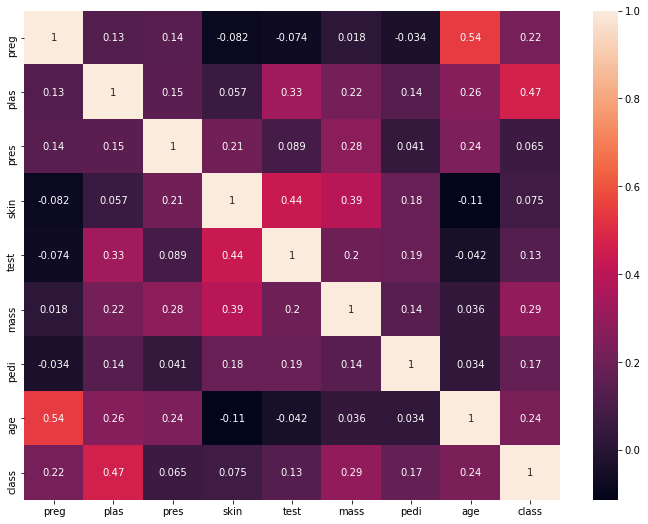

In [4]:
corr = dataframe.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr,annot=True)
plt.show()

Также можно посмотреть зависимости между конкретными переменными на графиках pairplot. Также здесь можно увидеть выбросы или пропущенные значения.

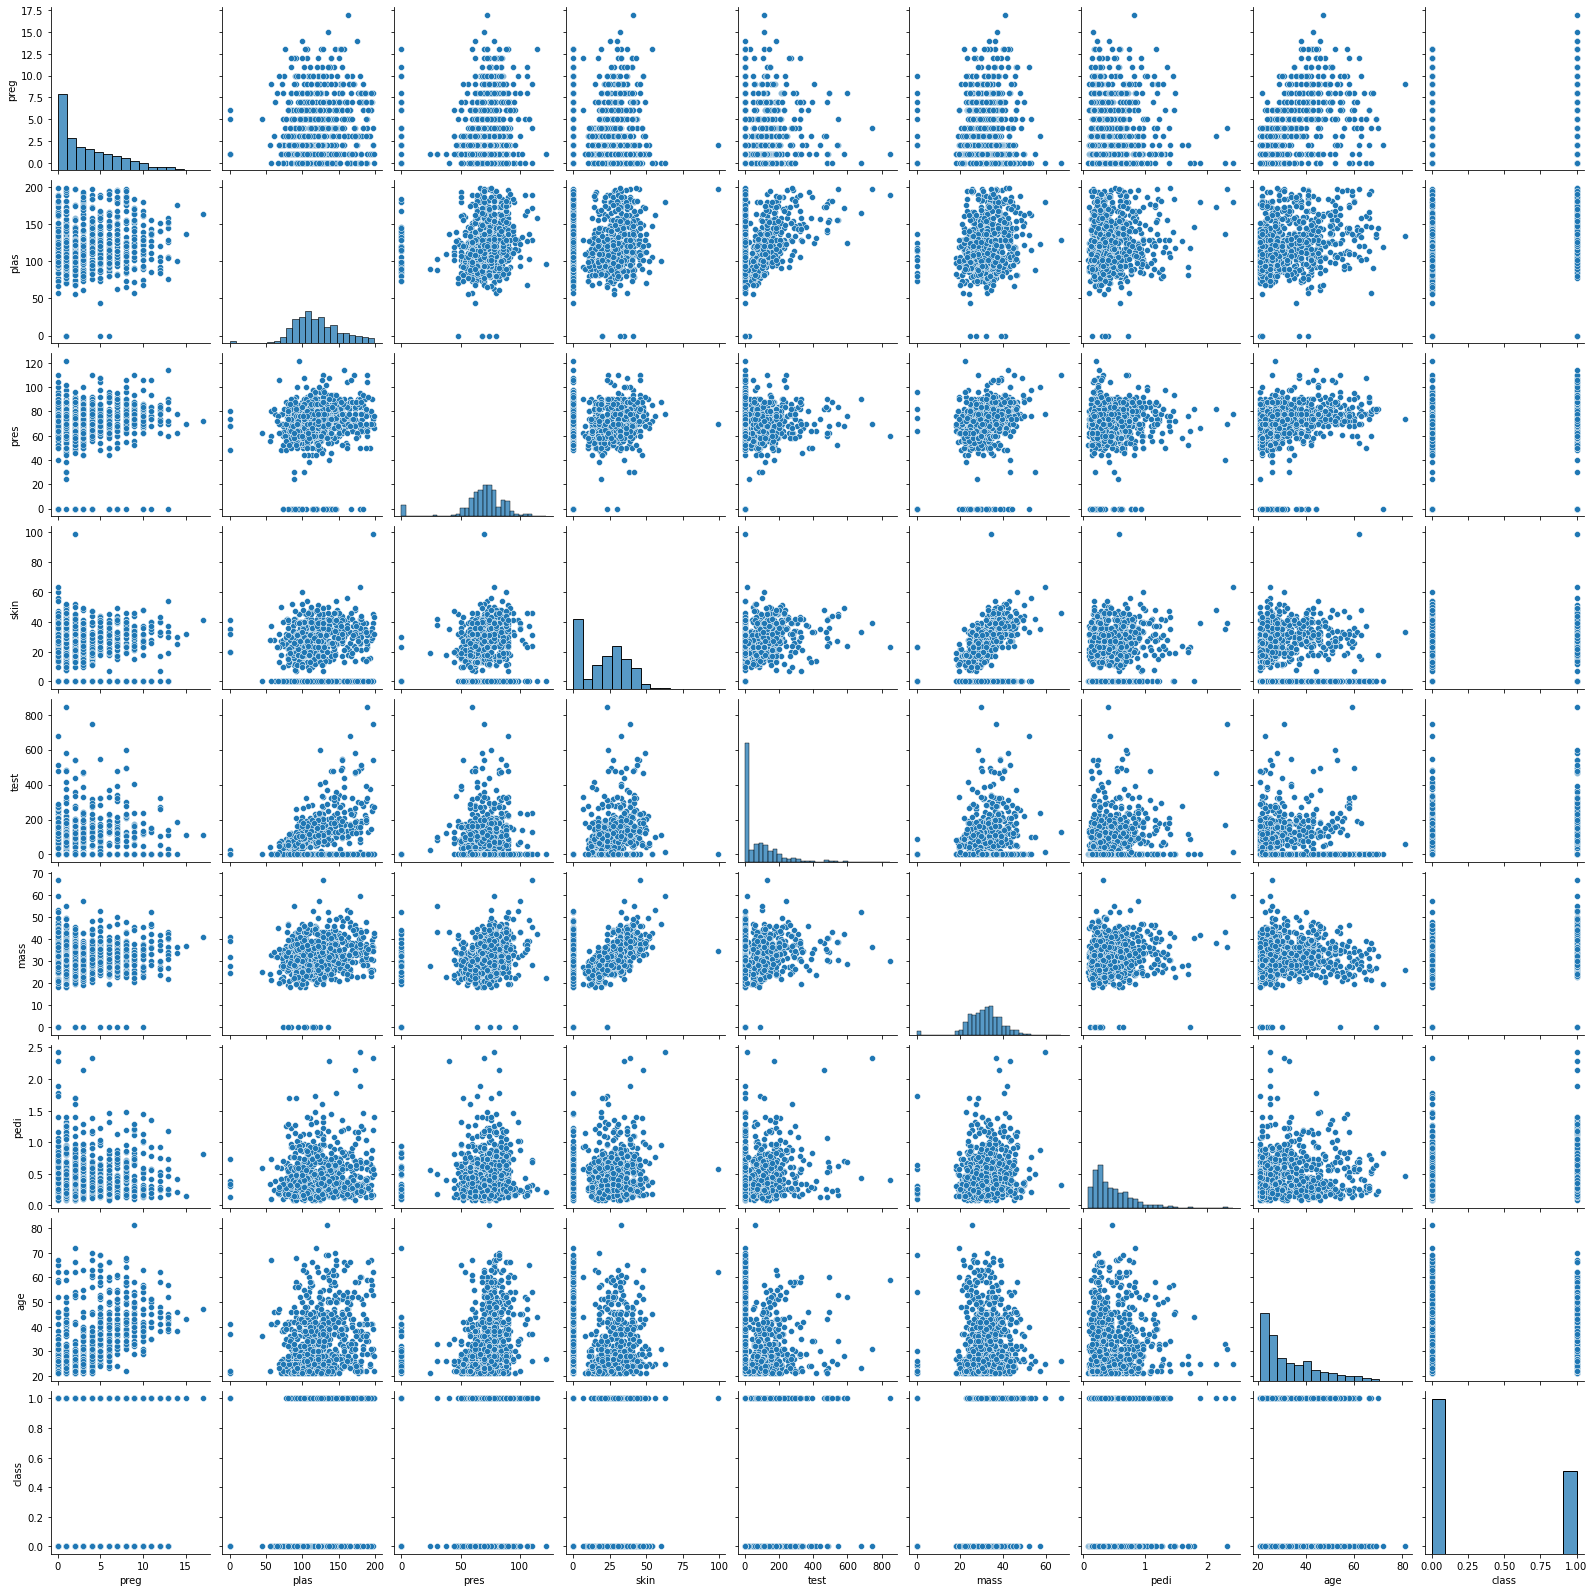

In [5]:
sns.pairplot(dataframe)

Далее построим модель на основе деревьев решений, и посмотрим важность признаков, которую она нам вернет. В итоге, снова получаем самый высокий коэффициент важности у одного признака ("plas"), которой мы видели и в матрице корреляций с таргетной переменной с наибольшей корреляцией.

In [6]:
array = dataframe.values
X = array[:,0:8] # dataframe --> массив numpy
Y = array[:,8]
# извлечение признаков
model = ExtraTreesClassifier()
model.fit(X, Y) # обучение
for i in range(len(names)-1):
    print(f"{names[i]}\t- {model.feature_importances_[i]:.4f}")

preg	- 0.1099
plas	- 0.2426
pres	- 0.1003
skin	- 0.0792
test	- 0.0753
mass	- 0.1367
pedi	- 0.1158
age	- 0.1401


In [9]:
array

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

Посмотрим важность признаков с точки зрения методов L1-регуляризации

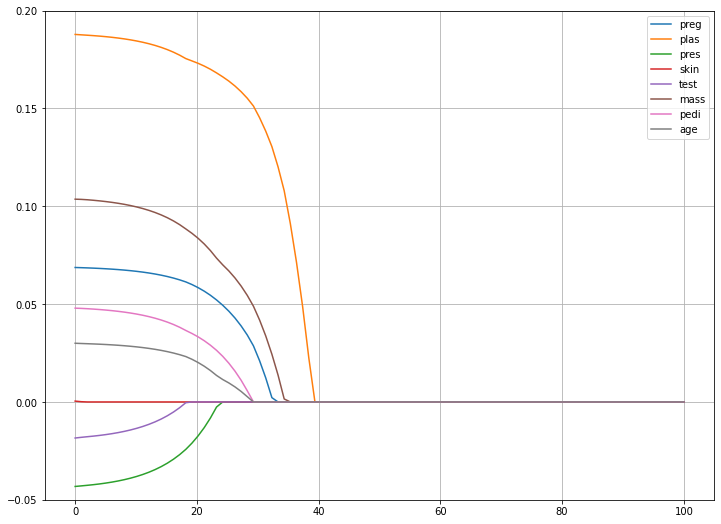

In [ ]:
from sklearn.linear_model import  Lasso # линейная модель с L1-регуляризацией
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

X_sc = StandardScaler().fit_transform(X) # преобразование данных
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,10,100))

# строим n-ое кол-во моделей Лассо, меняя коэффициент регуляризации, сохраняя модель и коэффициенты
for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(X_sc, Y)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

# рисуем отмасштабированные признаки на одном графике
plt.figure(figsize=(12,9))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
plt.ylim(-0.05,0.2)  
plt.legend(names)      
plt.grid()

Из этого графика можно видеть как сначала зануляются менее важные признаки, при малых значениях коэффициента, а затем по мере увеличения коэффициента регуляризации все остальные. Таким образом, можно делать выводы о важности тех или иных признаков.

### Последоватеольный отбор признаков

Жадная процедура,отбора признаков. Прямой подход - итеративно добавляем лучший признак из неотобранных для добавления к набору выбранных. Процедура останавливается, когда достигается желаемое количество выбранных функций.

Обратный проход - следует той же идее, но работает в противоположном направлении. Удаляет самые слабые признаки. 

https://scikit-learn.org/stable/modules/feature_selection.html

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3)
sfs.fit(X, Y)

SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                          n_features_to_select=3)

In [ ]:
for n, p in zip(names, sfs.get_support()):
    print(f"{n} - {p}")

preg - False
plas - True
pres - False
skin - True
test - False
mass - False
pedi - True
age - False


In [ ]:
sfs.transform(X).shape

(768, 3)

## Рекурсивное устранение признаков

Процедура последовательного удаления признаков. Оценка хорошести признака проводиться на основе оценки важности признака обучающимся алгоритмом (например coef_, feature_importances_). 

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X, Y)

In [ ]:
for n, p in zip(names, selector.support_):
    print(f"{n} - {p}")

preg - True
plas - False
pres - False
skin - False
test - False
mass - True
pedi - True
age - False


In [ ]:
for n, p in zip(names, selector.ranking_):
    print(f"{n} - {p}")

preg - 1
plas - 2
pres - 3
skin - 5
test - 6
mass - 1
pedi - 1
age - 4


<h2>Практика. PCA.</h2>
<p id="10">Рассмотрим метод главных компонент на практике. Сначала сделаем  его по алгоритму "руками", а затем рассмотрим готовый алгоритм.</p>

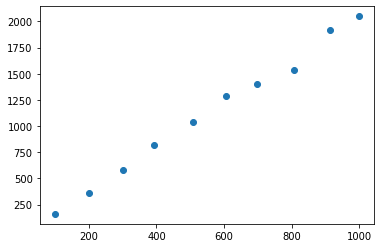

In [ ]:
# генерируем искусственные данные
x = np.arange(1,11) * (100 + np.random.randn(10))
y = 2 * x + np.random.randn(10)*50
X = np.vstack((x,y))
plt.scatter(x,y)

Далее действуем по алгоритму, по которому работает PCA. Для начала стандартизуем переменные.

In [ ]:
Xcentered = (X[0] - x.mean(), X[1] - y.mean()) # вычтем из переменных среднее значение
m = (x.mean(), y.mean())
print("Средние значения: ", m) # 

Средние значения:  (552.1940368739647, 1114.400395724511)


Посчитаем матрицу ковариаций. Делаем это с помощью бибилиотеки numpy.

In [ ]:
covmat = np.cov(Xcentered)
print(covmat, "\n")
print("Дисперсия X: ", np.cov(Xcentered)[0,0])
print("Дисперсия Y: ", np.cov(Xcentered)[1,1])
print("Ковариация X и Y: ", np.cov(Xcentered)[0,1])

[[ 93016.7678471  193874.98232744]
 [193874.98232744 406429.85838164]] 

Дисперсия X:  93016.767847104
Дисперсия Y:  406429.8583816447
Ковариация X и Y:  193874.98232744087


Далее раскладываем матрицу ковариаций на собственные вектора. Берем один собственный вектор и с помощью этого вектора преобразуем наши центрованные данные в новые данные. Теперь получается вектор, который уже повернут в новом пространстве.

In [ ]:
_, vecs = np.linalg.eig(covmat)
v = vecs[:,1]
Xnew = np.dot(v, Xcentered)
print(Xnew)

[ 1056.25608192   831.70959139   589.62521885   336.62487879
    87.21133948  -181.24347734  -321.20214698  -485.54457687
  -877.00316352 -1036.43374571]


В итоге, получаем восстановленные с достаточно хорошей точностью данные.

In [ ]:
n = 8     #номер элемента случайной величины
Xrestored = np.dot(Xnew[n],v) + m
print('Восстановленные: ', Xrestored)
print('Original: ', X[:,n])

Восстановленные:  [ 930.11180198 1905.79960703]
Original:  [ 913.24992387 1913.85167885]


Точно такую же операцию можно провернуть с помощью встроенного PCA.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1) # взяли 1 компоненту
XPCAreduced = pca.fit_transform(np.transpose(X)) # сделали трансформацию

Здесь мы можем видеть разницу между теми значениями, которые были в векторах и тем значением, которое мы получили после преобразования. Как видим все работает.

In [ ]:
for xn, x_pca in zip(Xnew, -XPCAreduced):
    print(xn, '-', x_pca[0], '=', np.abs(xn) - np.abs(x_pca[0]))

1056.2560819188814 - -1056.256081918881 = 4.547473508864641e-13
831.7095913852593 - -831.7095913852592 = 1.1368683772161603e-13
589.6252188487296 - -589.6252188487294 = 1.1368683772161603e-13
336.62487878927965 - -336.62487878927965 = 0.0
87.21133947895167 - -87.21133947895167 = 0.0
-181.2434773428522 - 181.24347734285217 = 2.842170943040401e-14
-321.2021469792832 - 321.2021469792832 = 0.0
-485.54457686610976 - 485.54457686610976 = 0.0
-877.0031635224157 - 877.0031635224155 = 1.1368683772161603e-13
-1036.4337457104396 - 1036.4337457104393 = 2.2737367544323206e-13


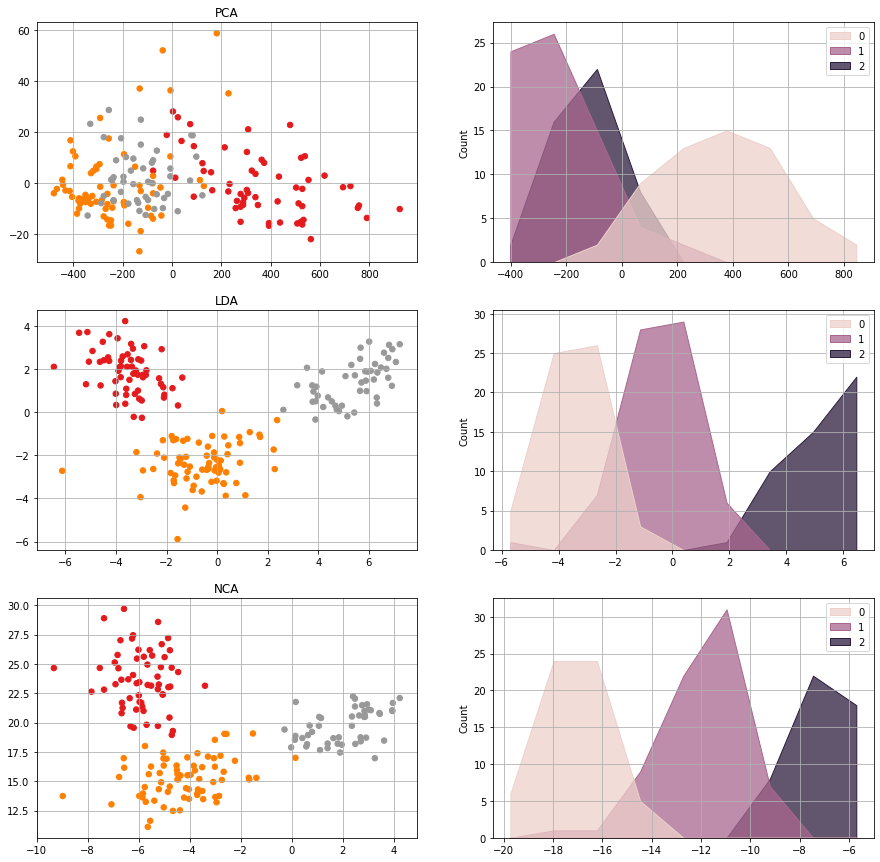

In [ ]:
X, y = datasets.load_wine(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

pca1 = PCA(n_components=1)
pca2 = PCA(n_components=2)

lda1 = LinearDiscriminantAnalysis(n_components=1)
lda2 = LinearDiscriminantAnalysis(n_components=2)

nca1 = NeighborhoodComponentsAnalysis(n_components=1)
nca2 = NeighborhoodComponentsAnalysis(n_components=2)

dim_reduction_methods = [('PCA', pca1, pca2), ('LDA', lda1, lda2), ('NCA', nca1, nca2)]

figure, axa = plt.subplots(3,2, figsize=(15,15))
    
for i, (name, model1, model2) in enumerate(dim_reduction_methods):
    
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)

    X_tr1 = model1.transform(X)
    X_tr2 = model2.transform(X)

    axa[i,0].scatter(X_tr2[:, 0], X_tr2[:, 1], c=y, s=30, cmap='Set1')
    sns.histplot(x=list(X_tr1.reshape(1,-1)[0]), hue=y, ax=axa[i,1], element="poly")
    axa[i,0].set_title(f"{name}")
    axa[i,0].grid()
    axa[i,1].grid()

plt.show()

<h2>Summary</h2>
<ol><li>Важнейшим этапом <b>предобработки</b> данных, помимо работы с выбросами и шумом, является <b>отбор признаков</b>, в тех случаях, когда признаков много, а объектов достаточно мало.</li><li>Следует помнить, что <b>скоррелированные признаки</b> могут достаточно сильно <b>усложнить</b> Вам работу при построении модели, и от них стоит <b>избавляться</b>.</li><li>Помимо  методов отбора признаков существуют методы <b>преобразования признаков</b>, которые в различных задачах достаточно <b>эффективны</b>.</li></ol>

<h3>Вопросы для самопроверки</h3>
<p><ol><li>Какие методы отбора признаков вы знаете? Для чего  нужно отбирать признаки?</li><li>В каких случаях достаточно эффетивно использовать преобразование существующих признаков?</li><li>В чем же разница между PCA и LDA, и что это такое?</li></ol></p>

<h1>Спасибо за внимание!</h1>